## **EX 2 - Classifying the data :)**

**Things to do:**
1. Try different feature selections and run all models on it
2. Write the report
3. fix confusion matrix printing
4. check data balance
5. one sided t-test

NOTES FOR GILAD
Tree:
* findBestXXX:
	changes a single param and find 


* base model - print metrics
* present tree
* $ we see overfitting, lets find the best depth
* findBestDepth
* print its metrics
* print it on dummies
* dt_models = {}
* base.get_params()
* prepare params dict
* & Random search
* & compare accuracy of base&random
* drig search
*compare accuracy
* plot hyper search (wat?)
* create ROC of base//rand//grid
* ttest between models

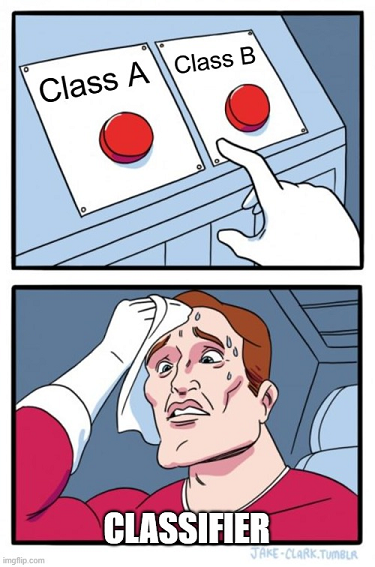

## These are important imports

In [ ]:
import sys
if not (sys.version_info.major == 3 and sys.version_info.minor >= 6):
    print("WARNING: OUTDATED PYTHON VERSION")
!py -3.8 -m pip --version
!py -3.8 -m pip install -r req.txt

In [39]:
import numpy as np
import pandas as pd
import seaborn as sb
import sklearn

import matplotlib.pyplot as plt
import geopandas as gpd

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split 
from sklearn import metrics  
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from imblearn.over_sampling import SMOTE

from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus
from IPython.display import display, HTML

import re
from time import sleep
from random import choice, sample
from itertools import combinations
from math import pow

In [2]:
sb.set(color_codes=True, rc={'figure.figsize': (5, 5)})
COLUMNS_IS_CATEGORY = "is_software	is_web	is_mobile	is_enterprise	is_advertising	is_gamesvideo	is_ecommerce	is_biotech	is_consulting	is_othercategory".split('\t')
COLUMNS_IN_STATE = "in_CA	in_NY	in_MA	in_TX	in_otherstate".split('\t')
ROUNDS = "roundA	roundB	roundC	roundD".split('\t')

In [42]:
# PART 2 PARAMETERS
THE_P_VALUE = 0.05
NUM_OF_FOLDS = 5
RAND = 42

## 1) Pre-processing

### Reading the CSV file:

In [6]:
data_frame_train = pd.read_csv("../part-1/startup_dataset.csv")
data_frame_test = pd.read_excel("./test_data.xlsx")

dfs = {'train': data_frame_train, 'test': data_frame_test}


### Data cleaning - check for each one of the problems and take care of them properly, e.g., missing values,  inconsistent  etc. 

#### Missing values

In [ ]:
def check_cleanness(df) -> None:
    are_all_good = True
    for title in df.columns:
        if df[title].isnull().sum() > 0:
            are_all_good = False
            print(f"titles {title} is {choice('dirty.smells.cheesy.ugly.stinky.boring'.split('.'))}")
    if are_all_good:
        print("Cleaning is done. All good!")

def create_country_col(df):
    for code in ['CA', 'NY', 'MA', 'TX', 'otherstate']:
        df.loc[df[f'in_{code}'] == 1, 'country'] = code

def fill_missing_vals(df):
    """
    fill missing values in country and first/last_milestone_age columns (same as part one)
    """
    # fill missing values in country column
    missing_country = df[df['country'].isnull()]
    for index in missing_country.index:
        state_code = df.loc[index, 'state_code']
        if state_code in ['CA', 'NY', 'MA', 'TX']:
            df.loc[index, 'country'] = state_code
        else:
            df.loc[index, 'country'] = 'otherstate'
    
    # fill missing values in the first/last_milestone_age columns
    null_indices = df['first_milestone_age'].isnull() | df['last_milestone_age'].isnull()

    features = ['first', 'last']
    for feature in features:
        df.loc[null_indices, f'{feature}_milestone_age'] = df.loc[~null_indices, f'{feature}_milestone_age'].min() - 10


    # df.loc[null_indices, 'first_milestone_age'] = df.loc[null_indices, 'last_milestone_age'] = -30
    # create a new column to indicate if the startup has milestones or not
    df.loc[null_indices, 'no_milestones'] = 1
    df.loc[~null_indices, 'no_milestones'] = 0

    print("All missing values are filled")


In [ ]:
for df in dfs.values():
    create_country_col(df)

let's check which columns are dirty... (has missing values :\ )

In [ ]:
for name, df in dfs.items():
    print(f"Before filling missing values - {name}")
    check_cleanness(df)
    print()

Same as part one we can see that the columns: 'country', 'first_milestone_age', 'last_milestone_age' have missing values.   
So we will fill them - 'country' according to the state_code, and the other two with the mean of the column, and we will create a new column 'no_milestone' that will be 1 if there is no milestone and 0 otherwise - that is because the missing values in the 'first_milestone_age' and 'last_milestone_age' columns are because there is no milestone, so we want to keep this information.

In [ ]:
for df in dfs.values():
    fill_missing_vals(df)

In [ ]:
# let's check again
for name, df in dfs.items():
    print(f"After filling missing values - {name}")
    check_cleanness(df)
    print()

#### Inconsistent data

First we can check if the state_code is consistent with the in_(state_code) values in the data_frame_test, changing the in_(state_code) according to the state_code.

In [ ]:
def check_binary_inconsistency(df, columns, label):
    association_word = columns[0][:2]
    for index in df[label].index:

        # x = data_frame_test.loc[index, columns].values#.sum()# == 1
        # x = next((col for (col, val) in zip(columns, x) if val==1)).strip("in_")
        category_code = df.loc[index, label].replace('_', '')
        good_code = f"{association_word}_{category_code}" if f"{association_word}_{category_code}" in columns else columns[-1]
    
        if df.loc[index, good_code] == 1:
            if df.loc[index, columns].values.sum() == 1:  # we have only one 1 :)
                continue
            else:  # we have more than one 1 :(
                df.loc[index, columns] = [0]*len(columns)
                df.loc[index, good_code] = 1  # save the good one

        else:  # we don't have a one in the good column
            print(f"wrong values at id={df.loc[index, 'id']}. fixing now...", end=" ")
            right_value = [0]*len(columns)
            right_value[columns.index(good_code)] = 1
            df.loc[index, columns] = right_value
            sleep(0.5)
            print("done.")
    
    print("All good! No more inconsistency.")

In [ ]:
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - state_code")
    check_binary_inconsistency(df, COLUMNS_IN_STATE, "state_code")
    print()

As we stated before, we had one inconsistent value in the state_code column (we observed it thanks to the country column we added), so we changed it to the correct value.

Secondly, we can check if the category is consistent with the is_(category) values in the data_frame_test, changing the is_(category) according to the category.

In [ ]:
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - category")
    check_binary_inconsistency(df, COLUMNS_IS_CATEGORY, "category")
    print()

We can also check the cities for inconsistency - here we also use the code from part 1

In [ ]:
for name, df in dfs.items():
    print(f"the cities in {name} data")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

We found some duplicates in the data (and typos :P), so we'll merge them into the same city.

In [ ]:
def check_cities(df):
    """Check for and fix inconsistency in cities column"""
    # from part-1
    inconsistency_cities = {'New York City': "NYC.NY.New York", 'Atlanta': 'NW Atlanta',
    'Hollywood': 'North Hollywood.West Hollywood', 'Reading': "North Reading", "Billerica": "North Billerica",
    "Spokane": "SPOKANE", 'San Francisco': "San Franciso.South San Francisco", "Sunnyvale": "Sunnnyvale", "Chester": "West Chester", 
    "Hollywood": "West Hollywood", "Newfield": "West Newfield"}

    for key, values in inconsistency_cities.items():
        for fix_from in values.split('.'):
            df.loc[df['city']==fix_from, "city"] = key

    # new things from this part
    for index in df.index:
        df.loc[index, "city"] = re.sub(r'[^a-zA-Z ]+', '', df.loc[index, "city"])  # remove all non-alphabetic characters

    print("All good! No more inconsistency.")

for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - city")
    check_cities(df)
    print()

In [ ]:
for name, df in dfs.items():
    print(f"The cities in {name} data - after fixing")
    x = np.sort(df["city"].unique())
    print("\n".join(x))
    print()

All good now :)

We can also check if the funding ages are consistent with the funding dates and foundation dates (should be the difference between them).

In [ ]:
def check_ages(df, age_col, date_col, ref_col):
    """Check if the age is consistent with the date according to the reference column"""
    # first we transform the date to a datetime object of pandas - this will help us to calculate the age :)
    df['foundation_date'] = pd.to_datetime(df['foundation_date'], format='%m/%d/%Y')
    df['first_funding_date'] = pd.to_datetime(df['first_funding_date'], format='%m/%d/%Y')
    df['last_funding_date'] = pd.to_datetime(df['last_funding_date'], format='%m/%d/%Y')

    for index in df[age_col].index:
        if df.loc[index, age_col] != round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4):  # age need to be the difference between the dates
            print(f"wrong values fixing now... ", end=" ")
            df.loc[index, age_col] = round((df.loc[index, date_col] - df.loc[index, ref_col]).days / 365, 4)  # fix the age
            sleep(0.5)
            print("done.")
    print(f"All good! No more inconsistency in the {age_col} column.")

# now fix the first_funding_age and last_funding_age columns
for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - first_funding_age, last_funding_age")
    check_ages(df, 'first_funding_age', 'first_funding_date', 'foundation_date')
    check_ages(df, 'last_funding_age', 'last_funding_date', 'foundation_date')
    print()

We can also check the rounds for inconsistency - total funding rounds should be at least the sum of the other rounds.

In [ ]:
def check_funding_rounds(df):
    """Check if the funding_rounds column is consistent with the other funding columns"""
    for index in df['funding_rounds'].index:
        if df.loc[index, ROUNDS].sum() > df.loc[index, 'funding_rounds']:
            print("wrong values fixing now... ", end=" ")
            df.loc[index, 'funding_rounds'] = df.loc[index, ROUNDS].sum()
            sleep(0.5)
            print("done.")

    print("All good! No more inconsistency in the funding_rounds column.")


for name, df in dfs.items():
    print(f"checking inconsistency in {name} data - funding_rounds")
    check_funding_rounds(df)
    print()

#### Outliers

In [ ]:
def find_outliers(df, col, positive=False):
    mean = df[col].mean()
    std = df[col].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std
    good_lower_bound = max(0, lower_bound) if positive else lower_bound
    return good_lower_bound, upper_bound, df[(df[col] < good_lower_bound) | (df[col] > upper_bound)]  # return the outliers

In [ ]:
OUTLIERS_CHECK_COLS = ['total_funding', 'connections', 'funding_rounds', 'milestones', 'avg_group_size']

def print_outliers(df):
    """Print for outliers in the given dateframe"""
    for col in OUTLIERS_CHECK_COLS:
        l_bound, u_bound, outliers = find_outliers(df, col, True)
        print(f"Outliers for {col}:\n\tlower bound: {l_bound}\n\tupper bound: {u_bound}")
        display(HTML(outliers.to_html()))
        print("\n")

for name, df in dfs.items():
    print(f"outliers in {name} data")
    print_outliers(df)
    print()

### Data transformation -  apply  data  transformations  that  will  allow  better  analysis  and  visualizations,  e.g.,  normalization,  discretization  etc.

#### Discretization

We we'll do discretization for the connections, funding_rounds, milestones, avg_group_size and avg_group_size columns, because we saw that they have outliers and we want to take them into account.   
We can use reasoning partition for them, to divide them into "reasonable" groups, and group the outliers apart from the others.   
The bins were decided according to the distribution of the data and the outliers we saw before.

In [ ]:
def discretize(df, col, bins):
    df[f"{col}_bins"] = pd.cut(df[col], bins=bins, labels=list(range(len(bins) - 1)), include_lowest=True)
    print(df[f"{col}_bins"].value_counts())
    plt.title(f"{col}_bins")
    df[f"{col}_bins"].value_counts().sort_index().plot.bar()
    plt.show()

In [ ]:
def discretize_and_plot(df):
    """discretize the data and plot the results"""
    connections = [0, 5, 10, 20, 30, df['connections'].max()]
    discretize(df, 'connections', connections)

    funding_rounds = [0, 1, 2, 3, 4, 6, df['funding_rounds'].max()]
    discretize(df, 'funding_rounds', funding_rounds)

    milestones = [0, 1, 2, 3, 4, 5, df['milestones'].max()]
    discretize(df, 'milestones', milestones)

    avg_group_size = [0, 1, 3, 5, 8, df['avg_group_size'].max()]
    discretize(df, 'avg_group_size', avg_group_size)

    df['state_code_bins'] = df['country'].map({state: i for i, state in enumerate(df['country'].unique())})
    plt.title('state_code_bins')
    df['state_code_bins'].value_counts().sort_index().plot.bar()
    plt.show()

    for col in COLUMNS_IS_CATEGORY:
        df.loc[df[col]==1, 'category_1'] = col.strip("is_")
    df['category_bins'] = df['category_1'].map({state: i for i, state in enumerate(df['category_1'].unique())})
    plt.title('category_bins')
    df['category_bins'].value_counts().sort_index().plot.bar()
    plt.show()

for name, df in dfs.items():
    print(f"discretize {name} data")
    discretize_and_plot(df)
    print()


### Drop columns

In [ ]:
def drop_columns(df):
    """drop columns that are not needed"""
    df = df.copy()
    droppings = ['id', 'state_code', 'latitude', 'longitude', 'zip_code', 'city', 'name',
       'first_funding_date', 'last_funding_date', 'connections', 'funding_rounds', 
       'milestones', 'category', 'avg_group_size', 'avg_group_size', 
       'state_code_codes', 'category_codes', 'city_codes', 
       'country', 'in_Top500_str', 'category_1'] + COLUMNS_IN_STATE + COLUMNS_IS_CATEGORY  # and nominal data-s
    return df.drop(set(droppings + ['no_milestones']) & set(df.columns), axis=1)

dfs_clean = {name: drop_columns(df) for name, df in dfs.items()}
for name, df in dfs_clean.items():
    print(f"Columns after dropping in {name} data")
    print(df.columns, end="\n\n")

In [ ]:
dfs_clean['train'].info()

In [ ]:
dfs_clean['test'].info()

### Normalization

First we need to fix the date columns, because they are not in the correct format - not a number

In [ ]:
# transform the data columns to be numeric, so we can normalize them :)
for name, df in dfs_clean.items():
    df['foundation_date'] = df['foundation_date'].astype('int64')
    print(f"=== Info of {name} ===")
    print(df.info())
    print()

Before we'll normalize the column of the total_funding we need to fix the outlier in it, because they will affect the normalization!
In order to do that, we will replace the outlier that we found earlier with the upper bound of the outlier in the column.

In [ ]:
def fix_out_total_funding(df):
    """Fix the total_funding column in the given dataframe"""
    lb, ub, o = find_outliers(df=df, col='total_funding')
    row = o.index.tolist()
    df.loc[row, 'total_funding'] = ub

In [ ]:
for df in dfs_clean.values():
    fix_out_total_funding(df)

In [ ]:
def normalize(data_f: pd.DataFrame, col_name: str) -> None:
    min_max_scaler = MinMaxScaler()  # min-max scaler normalizer between 0 and 1 :)
    min_max_scaler.fit(pd.DataFrame(data_f[col_name]))
    data_f[col_name] = min_max_scaler.transform(pd.DataFrame(data_f[col_name]))

def normalize_df(df):
    for col in df.columns:  # normalize all the columns that are not binary and not bins
        if df[col].nunique() > 2 and "_bins" not in col:  # check if not-binary and not bins
            normalize(df, col)

for name, df in dfs_clean.items():
    print(f"Normalize {name} data...", end="\t")
    normalize_df(df)
    print("done.")

Finally we will transform the Target column to 0 and 1, according to the value of the column (1 if the company was acquired, 0 if closed).

In [ ]:
dfs_clean['train'].loc[dfs_clean['train']['Target'] == 'acquired', 'Target'] = 1
dfs_clean['train'].loc[dfs_clean['train']['Target'] == 'closed', 'Target'] = 0

# transform the target column to be numeric
dfs_clean['train']['Target'] = dfs_clean['train']['Target'].astype('int64')

In [ ]:
dfs_clean['train'].head()

In [ ]:
dfs_clean['train'].info()

In [ ]:
dfs_clean['test'].head()

In [ ]:
dfs_clean['test'].info()

In [ ]:
for n, m in dfs_clean.items():
    m.to_csv(f'data_frame_{n}_clean.csv', index=False)

## 2) Classification, evaluation matrices and hyper-parameters

Load data for part 2 from CSV, in order to not run PART 1 again.

In [4]:
dfs_clean = {'train': None, 'test': None}
for n in dfs_clean.keys():
    dfs_clean[n] = pd.read_csv(f'data_frame_{n}_clean.csv')
df_train_clean = dfs_clean['train'].copy()
df_test_clean = dfs_clean['test'].copy()

### Some functions we will use later :)

In [34]:
"""
    Evaluates a classification model clf, after training it on data X, y
    the evaluation is done using K-folds: split into train-test and measure metrics
    
    Metrics which are calculated: Confusion table, Accuracy, Recall, Precision & F-Score
"""
def evaluate(X, y, clf):
    X = X.to_numpy()
    kf = KFold(n_splits=NUM_OF_FOLDS, shuffle=True, random_state=RAND)
    our_metrics = {'cm': [[], []], 'accuracy': [[], []], 'recall': [[], []], 'precision': [[], []], 'f-score': [[], []]}

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for i, (curr_x, curr_y) in enumerate([(X_train, y_train), (X_test, y_test)]):
            clf.fit(X_train, y_train)
            y_pred = clf.predict(curr_x)
            our_metrics['cm'][i].append(metrics.confusion_matrix(curr_y, y_pred))
            our_metrics['accuracy'][i].append(metrics.accuracy_score(curr_y, y_pred))
            our_metrics['recall'][i].append(metrics.recall_score(curr_y, y_pred, average='weighted'))
            our_metrics['precision'][i].append(metrics.precision_score(curr_y, y_pred, average='weighted'))
            our_metrics['f-score'][i].append(metrics.f1_score(curr_y, y_pred))
    return our_metrics


"""
    Prints the different metrics
"""
def print_metrics(our_metrics):
    groups = ['train', 'test']
    results = {g: {m: val[idx] for m, val in our_metrics.items()
                   if m != 'cm'}
               for idx, g in enumerate(groups)}
    

    confusion_metrices = {g: our_metrics['cm']
                   for idx, g in enumerate(groups)}
    for group_name, matrix in confusion_metrices.items():
        print(f"Confusion table of {group_name}:")
        conf_pd = pd.DataFrame(matrix)
        display(HTML(conf_pd.to_html()))
        
    
#     results2 = {
#         'train': {
#             'Accuracy': our_metrics['accuracy'][0],
#             'Recall': our_metrics['recall'][0],
#             'Precision': our_metrics['precision'][0],
#             'F-score': our_metrics['f-score'][0] },
#         'test': {
#             'Accuracy': our_metrics['accuracy'][1],
#             'Recall': our_metrics['recall'][1],
#             'Precision': our_metrics['precision'][1],
#             'F-score': our_metrics['f-score'][1] }
#     }

    for group_name, group_metrics in results.items():
        print(f"Metrics for {group_name} set:")
        results_df = pd.DataFrame(group_metrics)
        mean_results = results_df.mean().to_frame().T
        mean_results.index = ['Mean']
        results_df = pd.concat([results_df, mean_results])
        results_df.index.name = '#Fold'
        # results_df = results_df.append(mean_results)
        display(HTML(results_df.to_html()))

        
# Splits Target column of DF into X, y
def split_train_result(df):
    X = df.drop(columns='Target')
    y = df['Target']
    return X, y


# adds dummy columns to DF where there are a few different values
def create_dummies(df):
    dummies_col = []
    for col in df:
        unique_values = len(df[col].unique())
        if 2 < unique_values < 8:
            dummies_col.append(col)

    return pd.get_dummies(data=df, columns=dummies_col)


def plot_hyper_search(hyper_search_models, x_axis_name):
    for name, model in hyper_search_models.items():
        test_scores = model.cv_results_['mean_test_score']
        param_values = list(model.cv_results_[f"param_{x_axis_name.replace(' ', '_')}"])
        # print(test_scores)

        plt.plot(param_values, test_scores, label=f'{name} test')
    plt.xlabel(x_axis_name)
    plt.ylabel('Test Accuracy')
    plt.title(f'Score vs {x_axis_name}')
    plt.legend()

In [281]:
# only get accuracy of a model based on train & test DFs
def calc_accuracy(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics.accuracy_score(y_test, y_pred)


# compares accuracy of two models, prints their difference
def compare_accuracy(X_train, y_train, X_test, y_test, model1, model2):
    accuracies = []
    for model in (model1, model2):
        clf = model[0]
        name = model[1]
        
        accuracy = calc_accuracy(X_train, y_train, X_test, y_test, clf)
        accuracies.append(accuracy)
        acc_percent = accuracy*100
        print(f"[{name}] model accuracy = {acc_percent:0.2f}%")
        
    improvment_factor = 100 * (accuracies[1] - accuracies[0]) / accuracies[0]
    print(f'Improvement of {improvment_factor:0.2f}%')


def createROC(X_train, y_train, X_test, y_test, models, plot=True):
    plt.figure(figsize=(8, 6))
    aucs = {}
    
    for model in models:
        name = model[1]
        model = model[0]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        fpr, tpr, ths = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        if plot:
            plt.plot(fpr, tpr, label=f'{name} model (AUC = {auc:0.2f})')

        aucs[name] = auc
    
    if plot:
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random model
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend()
        plt.show()
    return aucs


def ttest(model1_metric, model2_metric, model1_name, model2_name):
    if model1_metric == model2_metric:
        print(f"{model1_name} and {model2_name} have the same metric => No one is better than the other")
        return
    ttest, pval = stats.ttest_rel(model1_metric, model2_metric)  # put here less..  , alternative='greater'
    print("p-value:" , pval)
    if pval < THE_P_VALUE:
        # print(f"reject null hypothesis => {model1_name} is WORST THAN {model2_name}")
        if model1_metric > model2_metric:
            print(f"reject null hypothesis => {model1_name} is BETTER THAN {model2_name}")
        else:
            print(f"reject null hypothesis => {model2_name} is BETTER THAN {model1_name}")
    else:
        print(f"accept null hypothesis => No one of {model1_name} and {model2_name} is better than the other")  # {model1_name} is BETTER THAN {model2_name}


def ttest_all_metrics(all_models_metrics):
    # metrics_names = list(filter(lambda x: x!= 'cm', all_models_metrics['base'].keys()))
    metrics_names = ['accuracy', 'recall', 'precision', 'f-score']
    # check ttest of each metric and each pair of model trees
    for metric in metrics_names:
        print(f'--------- metric for ttest: {metric} ---------')
        combs = combinations(all_models_metrics.items(), 2)
        for (n1, m_dict1), (n2, m_dict2) in combs:
            ttest(m_dict1[metric][1], m_dict2[metric][1], n1, n2)
        print()   

## Check balance of data:

In [77]:
def display_target_distribution(df):
    X, y = split_train_result(df)

    map = {0: "Closed", 1: "Acquired"}
    vals_tmp = y.value_counts()
    vals = np.array([vals_tmp[x] for x in map.keys()], dtype=int)
    lbls = [y for y in map.values()]

    # from https://stackoverflow.com/questions/41088236
    def absolute_value(val):
        return f"{val:1.1f}%\n{np.round(val/100.*vals.sum(), 0).astype(int)}"
    _ = plt.pie(vals, labels=lbls, autopct=absolute_value) # '%1.1f%    %'
    
    y.value_counts()


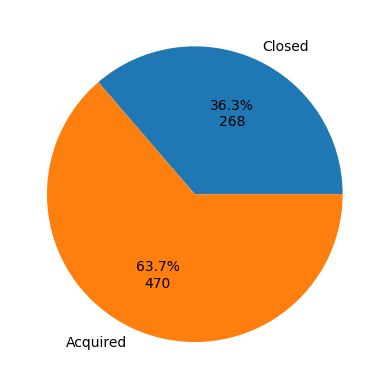

In [78]:
display_target_distribution(df_train_clean)

We see that the data is imbalanced! This can lead to a bias towards the Acquired target in prediction.
To fix this we will use SMOTE:

In [48]:
smote_oversampler = SMOTE(random_state=RAND)
smote_X, smote_y = smote_oversampler.fit_resample(X, y)

# combine smote_X & smote_y into one dataframe
smote_df = smote_X.copy()
smote_df['Target'] = smote_y
smote_df.head()

foundation_date  first_funding_age  last_funding_age  first_milestone_age  \
0         0.785287           0.365061          0.389409             0.590288   
1         0.546270           0.458030          0.615461             0.638124   
2         0.860722           0.325749          0.325749             0.524563   
3         0.614601           0.393572          0.464142             0.617597   
4         0.907553           0.292368          0.346291             0.495515   

   last_milestone_age  total_funding  roundA  roundB  roundC  roundD  \
0            0.533779       0.000548       0       0       0       0   
1            0.541594       0.060504       0       1       1       1   
2            0.417135       0.003906       1       0       0       0   
3            0.515592       0.060353       0       1       1       1   
4            0.360945       0.001944       0       0       0       0   

   in_Top500  connections_bins  funding_rounds_bins  milestones_bins  \
0          0                 0                    2                2   
1          1                 1                    3                0   
2          1                 0                    0                1   
3          1                 0                    2                0   
4          1                 0                    1                0   

   avg_group_size_bins  state_code_bins  category_bins  Target  
0                    0                0              0       1  
1                    2                0              1       1  
2                    2                0              2       1  
3                    2                0              3       1  
4                    0                0              4       0

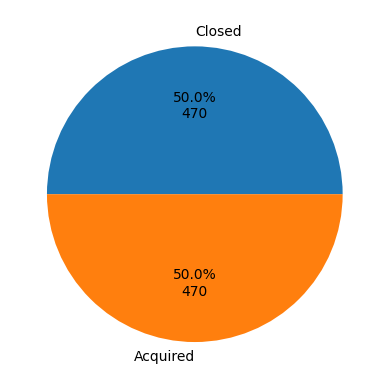

In [79]:
display_target_distribution(smote_df)

Now that the data is **balanced,** we will start looking for the best classification model. First we'll split the cleaned train data into X and Y (regular and dummy):

In [82]:
switch using the smote_df thingy? compare the two fits using regular  & smote datasets?
raise NotImplemented

Object `datasets` not found.


TypeError: exceptions must derive from BaseException

In [7]:
X, y = split_train_result(df_train_clean)
dummies_df = create_dummies(df_train_clean)
Xd, Yd = split_train_result(dummies_df)

## [A] Decision Tree Classifier

In [8]:
def findBestDepth(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    for k in range(2, 25):
        clf = DecisionTreeClassifier(criterion='entropy', splitter='best', 
                            max_depth=k, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(range(2,25), train_scores)
    plt.plot(range(2,25), test_scores)
    plt.xticks(range(2,25))
    plt.legend(['train', 'test'])
    plt.xlabel('max_depth')
    plt.ylabel('accuracy')
    plt.show()
    
    return np.argmax(test_scores) + 2, test_scores[np.argmax(test_scores)]

In [9]:
def presentTree(tree, X):
    dot = export_graphviz(tree, filled=True, rounded=True, special_characters=True, feature_names = X.columns, class_names=['0','1'])
    graph = pydotplus.graph_from_dot_data(dot)  
    display(Image(graph.create_png()))

Check the classic Decision Tree Classifier on our data split to train and validation set.

In [10]:
base_tree_model = DecisionTreeClassifier(random_state=RAND)

In [11]:
X, y = split_train_result(df_train_clean)

In [12]:
print_metrics(evaluate(X, y, base_tree_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


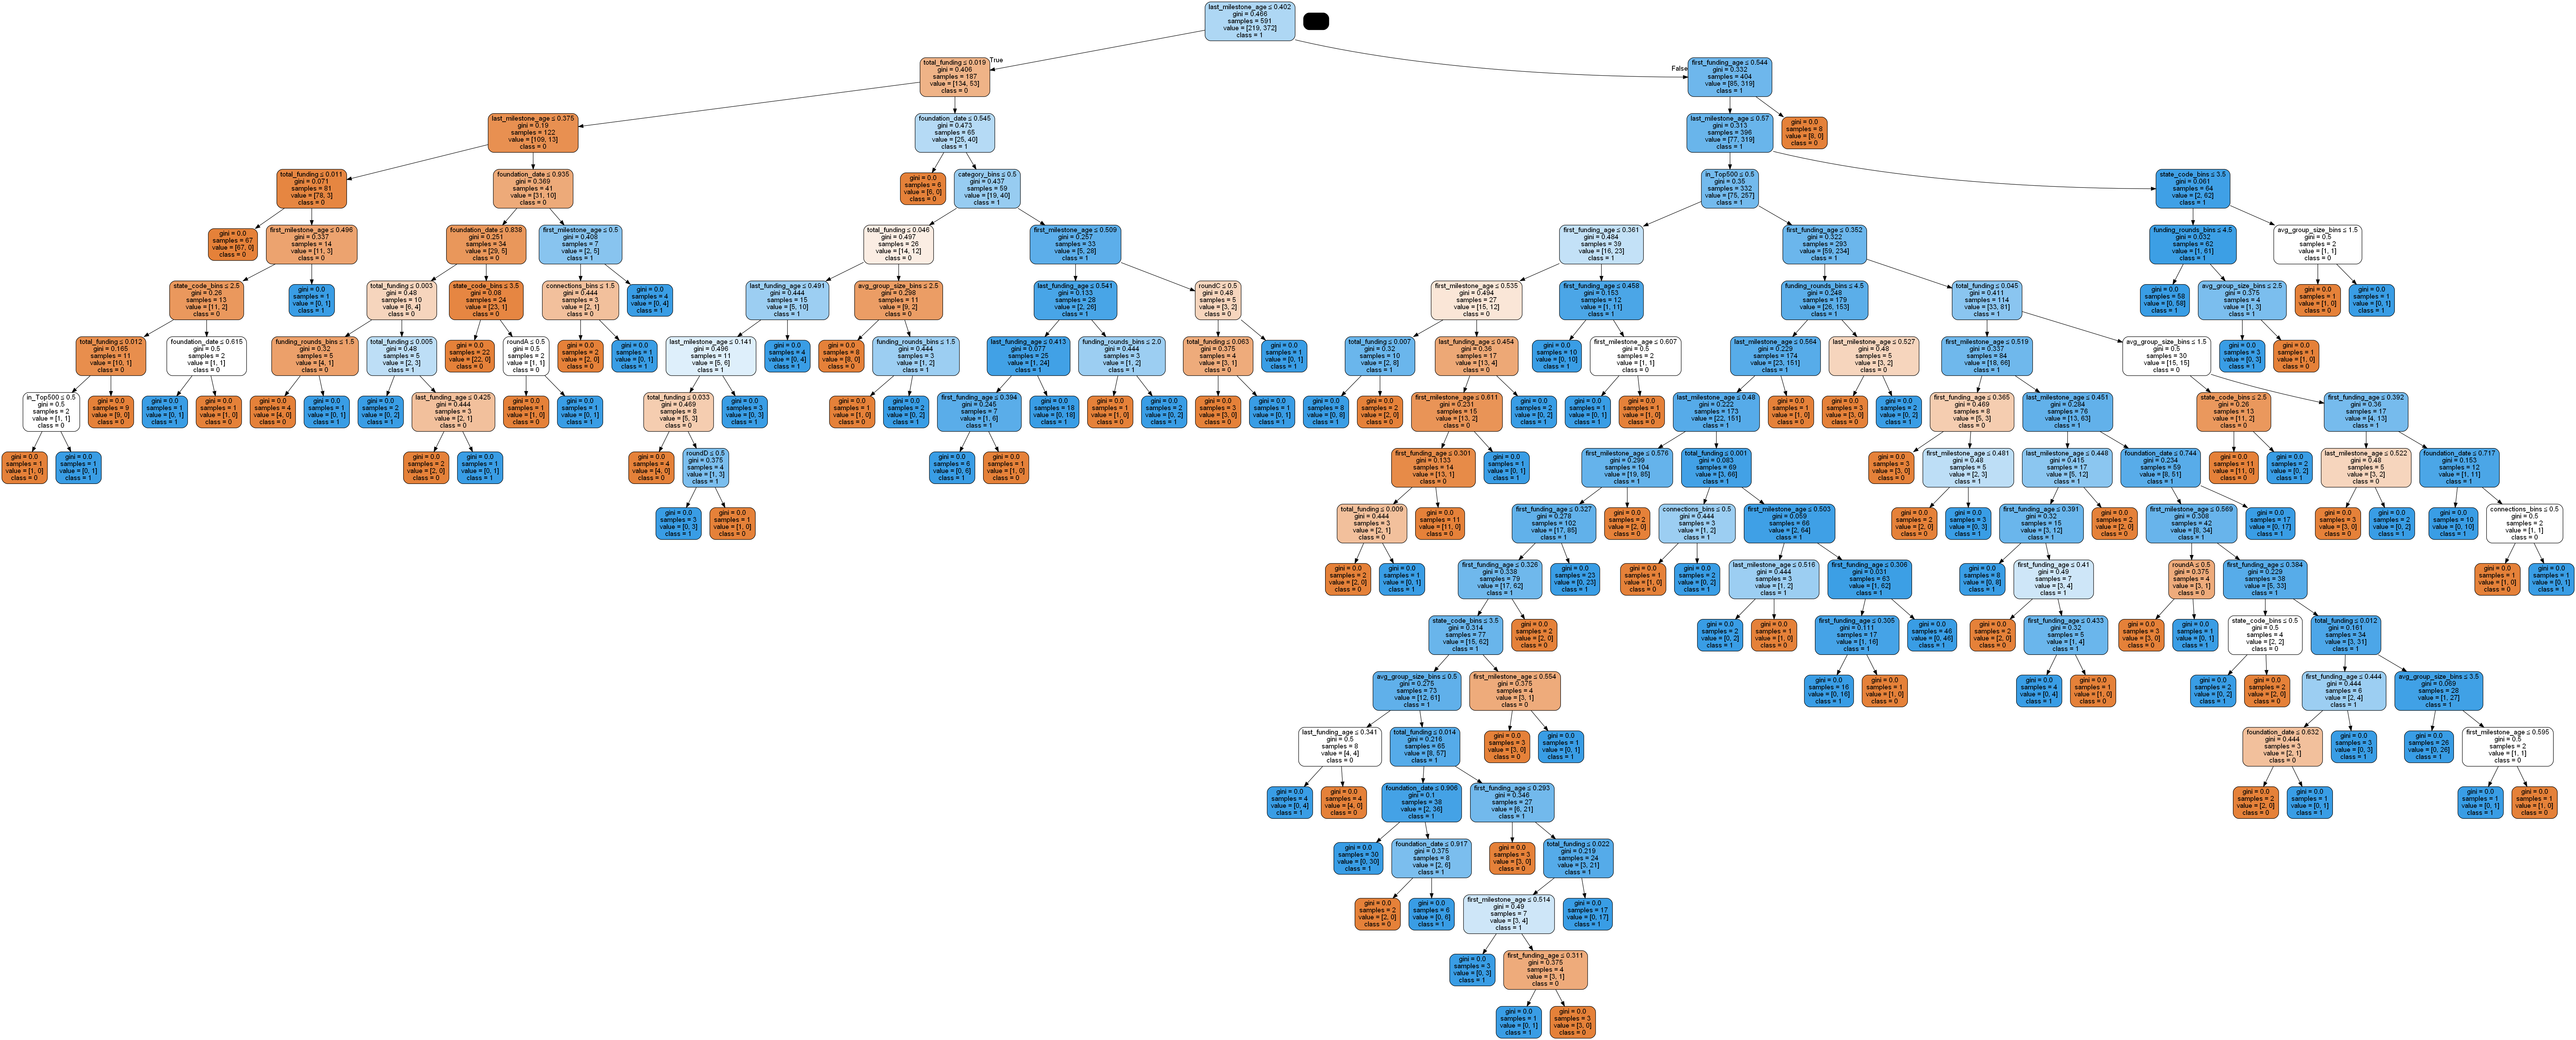

In [13]:
presentTree(base_tree_model, X)

We can see that the accuracy is not so good and we've got overfitting, so we'll try to improve it, by finding the best depth for the tree.

Split the data and check the accuracy of the decision tree model on the validation set - find the best depth for the tree.

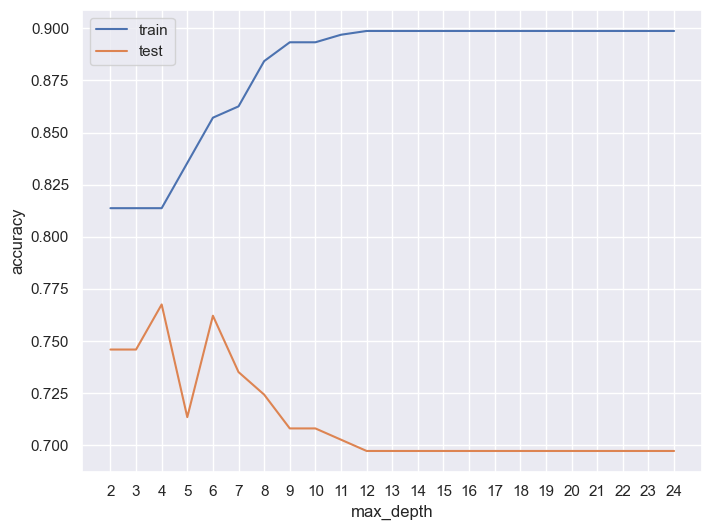

The best depth is 4 with accuracy of 0.7675675675675676


In [14]:
best_depth, best_depth_acc = findBestDepth(X, y)
print(f'The best depth is {best_depth} with accuracy of {best_depth_acc}')

We'll use the best depth we found for the decision tree model.

In [15]:
best_depth_clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
print_metrics(evaluate(X, y, clf=best_depth_clf))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


We can see that now we don't have overfitting and the accuracy of the test (of the cross validation) is better.

Now let's check the accuracy of the decision tree model with this depth on the train set with **dummies**.

In [16]:
print_metrics(evaluate(Xd, Yd, clf=best_depth_clf))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


Overall the dummies didn't help us, so we'll continue without them. 

Our accuracy isn't very good, so we'll try to improve it by using a hyperparameter tuning.

In [17]:
dt_models = {'base': base_tree_model, 'random': None, 'grid': None}

In [18]:
base_tree_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [19]:
criterion = ['gini', 'entropy']
max_depth = list(range(3, 8))
min_samples_split = list(range(11, 17))
min_samples_leaf = list(range(4, 7))
splitter = ['best', 'random']

param_grid = {'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'splitter' : splitter,
               'min_samples_leaf': min_samples_leaf
               }

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

dt_random = RandomizedSearchCV(estimator=base_tree_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=2, random_state=RAND, n_jobs=-1)

dt_random.fit(X_train, y_train)

dt_models['random'] = dt_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [21]:
dt_random.best_params_

{'splitter': 'best',
 'min_samples_split': 14,
 'min_samples_leaf': 6,
 'max_depth': 3,
 'criterion': 'entropy'}

In [22]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_tree_model, 'base'), (dt_random.best_estimator_, 'random'))

[base] model accuracy = 69.73%
[random] model accuracy = 74.59%
Improvement of 6.98%


Now let's see the tree with the best hyperparameters 

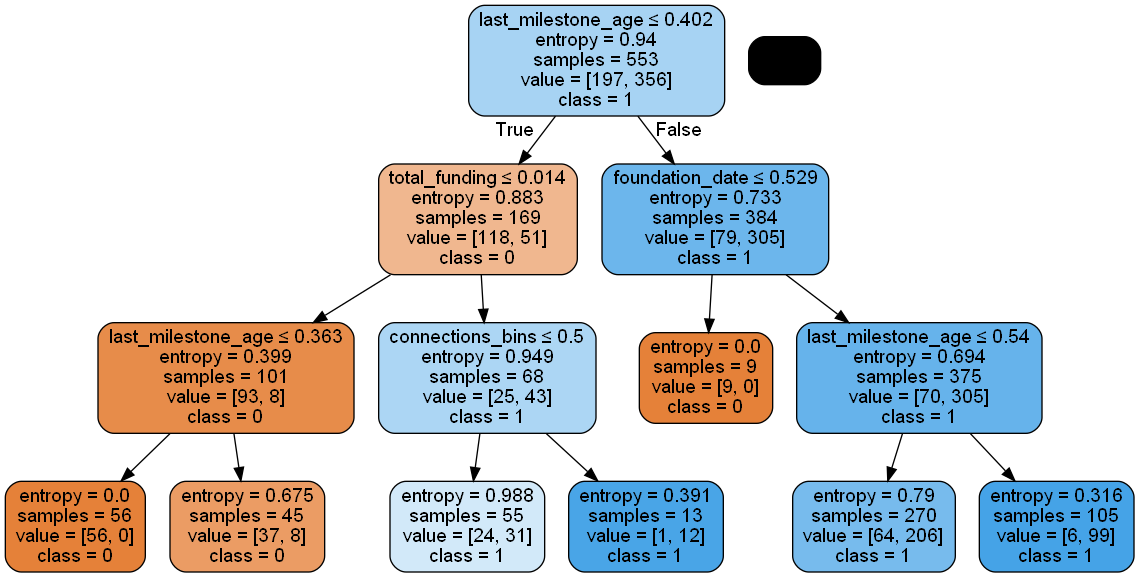

In [23]:
presentTree(dt_random.best_estimator_, X)

In [24]:
dt_grid = GridSearchCV(estimator=base_tree_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

dt_grid.fit(X_train, y_train)

dt_models['grid'] = dt_grid.best_estimator_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [25]:
dt_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 6,
 'min_samples_split': 11,
 'splitter': 'best'}

In [26]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_tree_model, 'base'), (dt_grid.best_estimator_, 'grid'))

[base] model accuracy = 69.73%
[grid] model accuracy = 74.59%
Improvement of 6.98%


let's see the new tree

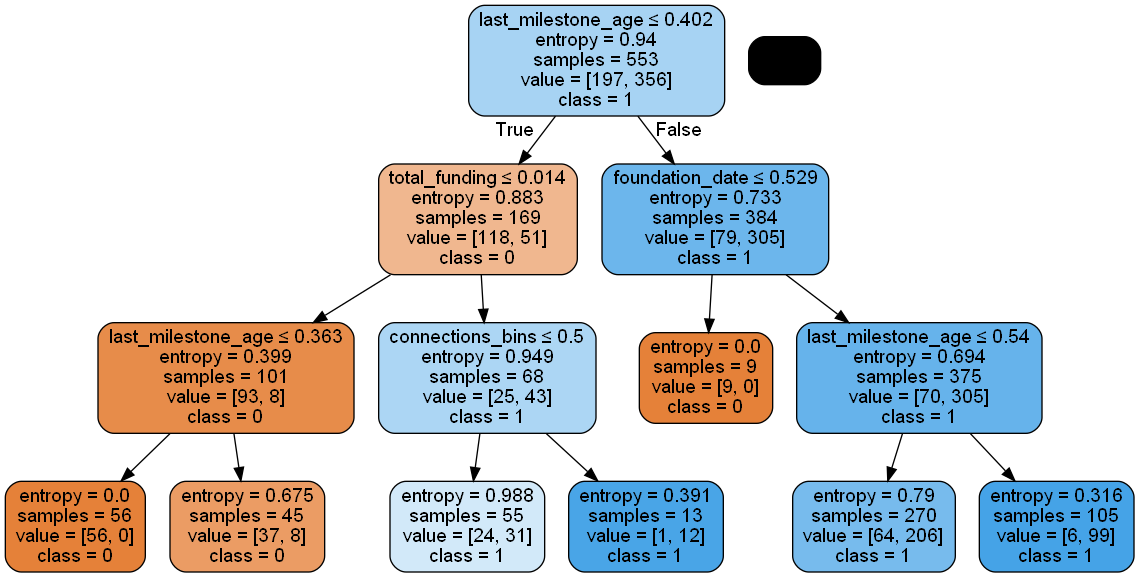

In [27]:
presentTree(dt_grid.best_estimator_, X)

In [ ]:
plot_hyper_search({'random': dt_random, 'grid': dt_grid}, 'max depth')

Now let's see the ROC curve and the AUC score of the decision tree model with this depth on the train set.

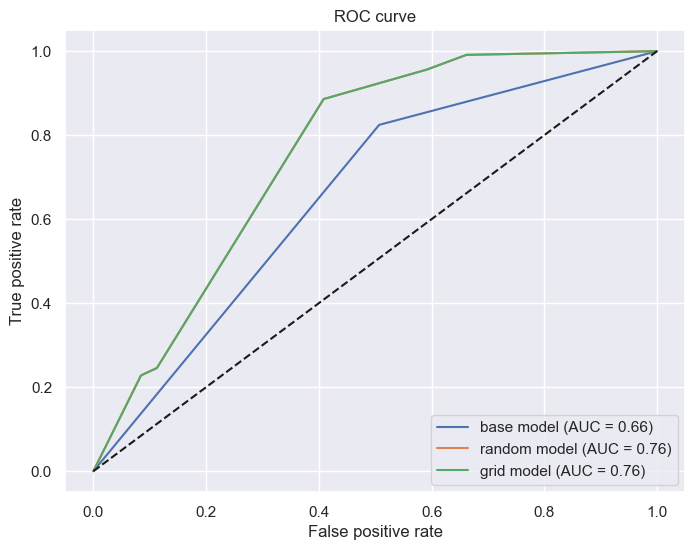

In [28]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_tree_model, 'base'), (dt_random.best_estimator_, 'random'), (dt_grid.best_estimator_, 'grid')])

We can see that the grid model got the best AUC.   
Now we will decide the best model according to the ttest.

In [112]:
dt_models_metrics = {n: evaluate(X, y, m) for n, m in dt_models.items()}

ttest_all_metrics(dt_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.014691097263404389
reject null hypothesis => random is BETTER THAN base
p-value: 0.014691097263404389
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: recall ---------
p-value: 0.014691097263404389
reject null hypothesis => random is BETTER THAN base
p-value: 0.014691097263404389
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: precision ---------
p-value: 0.008230223105704459
reject null hypothesis => random is BETTER THAN base
p-value: 0.008230223105704459
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: f-score ---------
p-value: 0.007516508690250247
reject null hypothesis => random is BETTER THAN base
p-value: 0.007516508

Overall the random and grid models are better than the classic model, and no difference between them.
So we will choose the grid model.

In [30]:
print_metrics(dt_models_metrics['grid'])

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


## [B] RandomForest Classifier 

In [31]:
def findBestNumTrees(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    for k in range(10, 1000, 66):
        clf = RandomForestClassifier(criterion='entropy', n_estimators=k,
                            max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(range(10, 1000, 66), train_scores)
    plt.plot(range(10, 1000, 66), test_scores)
    plt.xticks(range(10, 1000, 66))
    plt.legend(['train', 'test'])
    plt.xlabel('best num of trees')
    plt.ylabel('accuracy')
    plt.show()
    
    return np.argmax(test_scores)*66 + 10, test_scores[np.argmax(test_scores)]

In [59]:
base_rf_model = RandomForestClassifier(random_state=RAND)

In [60]:
print_metrics(evaluate(X, y, base_rf_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


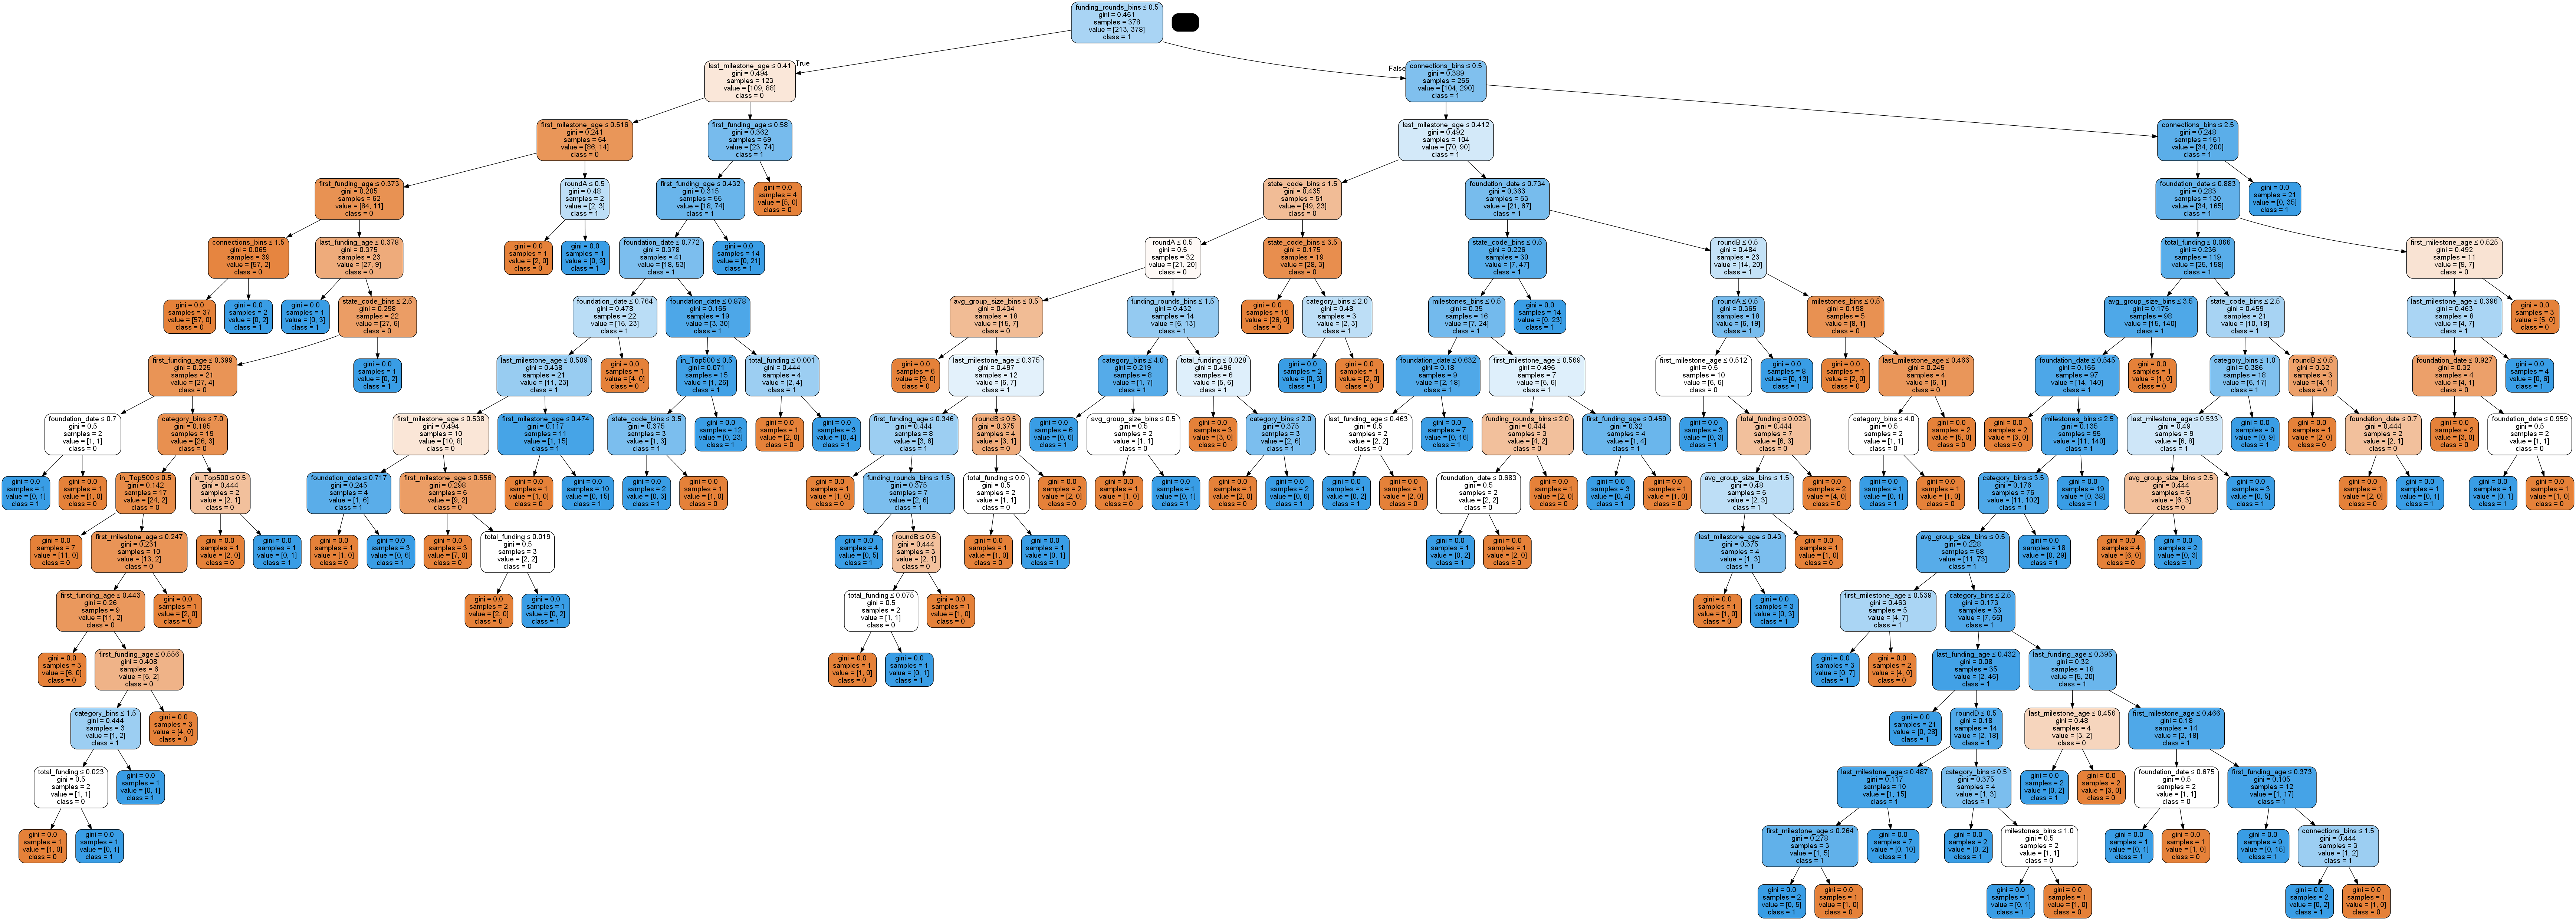

In [61]:
presentTree(base_rf_model.estimators_[0], X)

Just like before, we got overfitting, so let's try to find the best hyper-parameters for the random forest model. We'll start from number of trees.

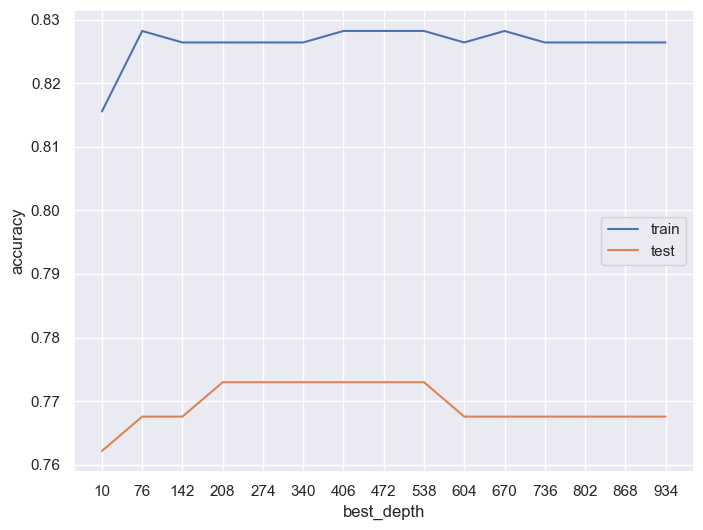

The best number of trees is 208 with accuracy of 0.772972972972973


In [62]:
best_num, best_num_acc = findBestNumTrees(X, y)
print(f'The best number of trees is {best_num} with accuracy of {best_num_acc}')

In [63]:
print_metrics(evaluate(X, y, clf=RandomForestClassifier(criterion='entropy', n_estimators=best_num,
                            max_depth=best_depth, min_samples_split=15, min_samples_leaf=5, random_state=RAND)))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


Again not great accuracy, so we'll try to improve it using hyperparameter tuning.

In [64]:
rf_models = {'base': base_rf_model, 'random': None, 'grid': None}

In [65]:
base_rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [66]:
n_estimators = [x for x in range(200, 600, 30)]
max_features = ['log2', 2, 5, 7]
max_depth = [int(x) for x in range(2, 8)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 3, 5, 10]
max_samples = [0.3, 0.5, 0.7]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

rf_random = RandomizedSearchCV(estimator=base_rf_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=2, random_state=RAND, n_jobs=-1)

rf_random.fit(X_train, y_train)

rf_models['random'] = rf_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [68]:
rf_random.best_params_

{'n_estimators': 590,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.5,
 'max_features': 7,
 'max_depth': 4}

In [69]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_rf_model, 'base'), (rf_random.best_estimator_, 'random'))

[base] model accuracy = 76.22%
[random] model accuracy = 77.30%
Improvement of 1.42%


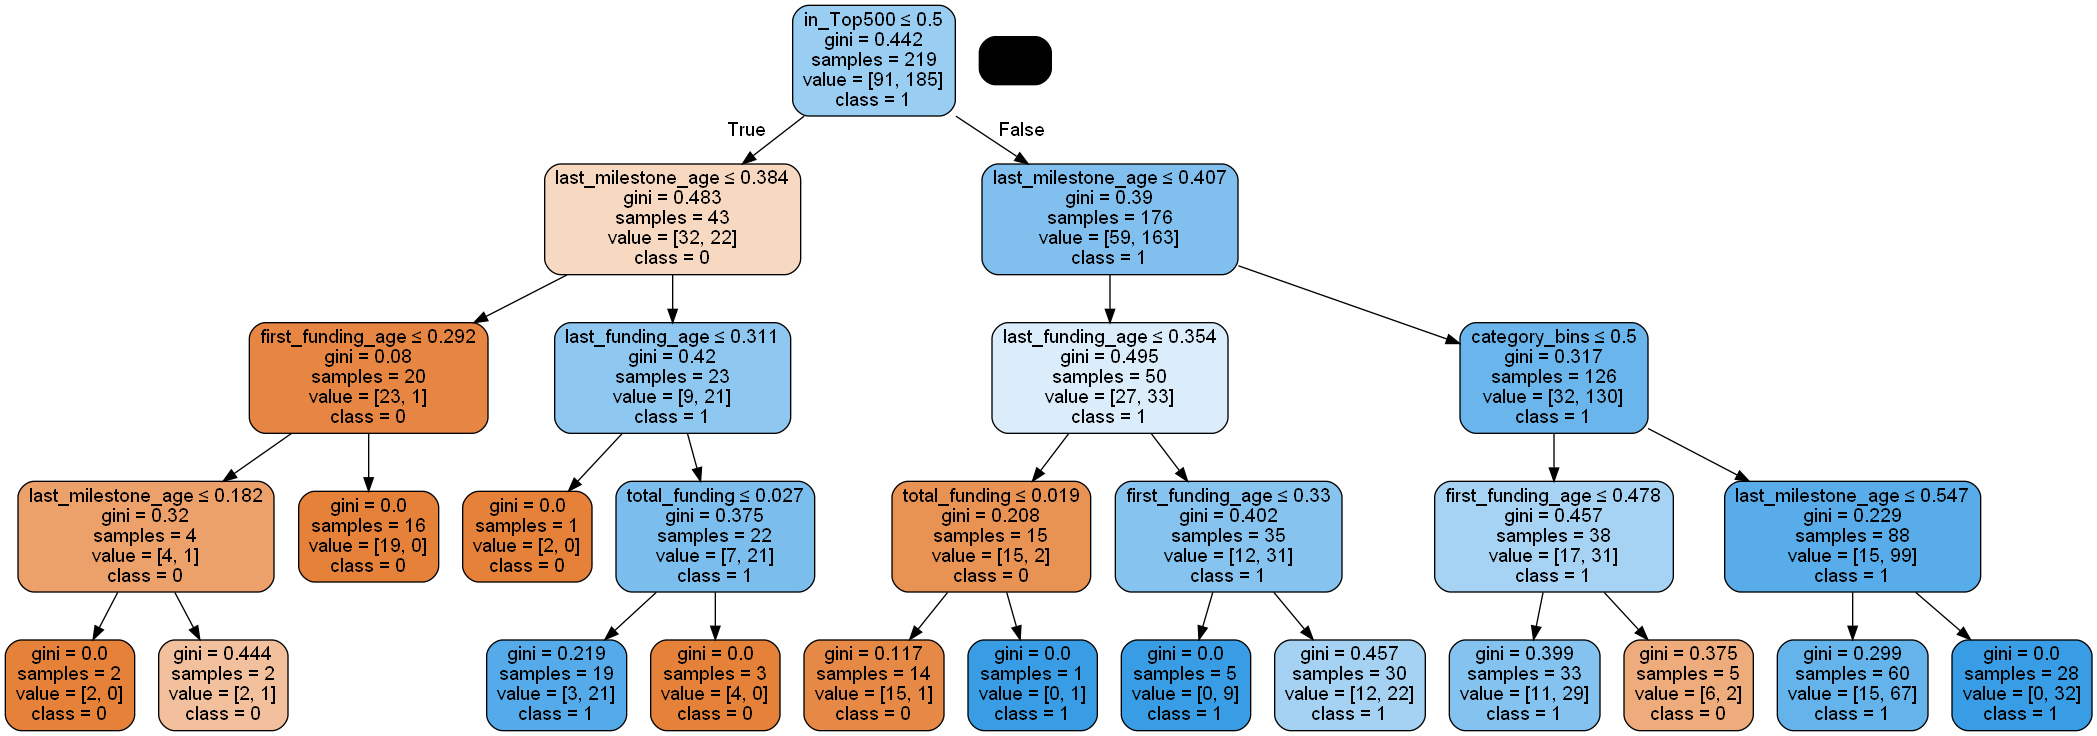

In [43]:
presentTree(rf_random.best_estimator_.estimators_[0], X)

In [44]:
rf_grid = GridSearchCV(estimator=base_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

rf_grid.fit(X_train, y_train)
rf_models['grid'] = rf_grid.best_estimator_

Fitting 5 folds for each of 18816 candidates, totalling 94080 fits


In [46]:
rf_grid.best_params_

{'max_depth': 4,
 'max_features': 7,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 440}

In [45]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_rf_model, 'base'), (rf_grid.best_estimator_, 'grid'))

[base] model accuracy = 76.22%
[grid] model accuracy = 76.76%
Improvement of 0.71%


For some reason the grid model didn't got the results like the random model, so we'll try it again with parameters that are closer to the random model.

In [198]:
n_estimators = list(range(560, 600, 30))
max_features = [5, 7]
max_depth = list(range(3, 6))
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 3]
max_samples = [0.3, 0.5]



param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_samples': max_samples}

In [199]:
rf_grid2 = GridSearchCV(estimator=base_rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

rf_grid2.fit(X_train, y_train)
# rf_models['grid'] = rf_grid.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5], 'max_features': [5, 7],
                         'max_samples': [0.3, 0.5], 'min_samples_leaf': [1, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [560, 590]},
             verbose=2)

In [200]:
rf_grid2.best_params_

{'max_depth': 4,
 'max_features': 7,
 'max_samples': 0.5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 590}

In [201]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_rf_model, 'base'), (rf_grid2.best_estimator_, 'grid'))

[base] model accuracy = 76.22%
[grid] model accuracy = 77.30%
Improvement of 1.42%


In [202]:
rf_models['grid'] = rf_grid2.best_estimator_

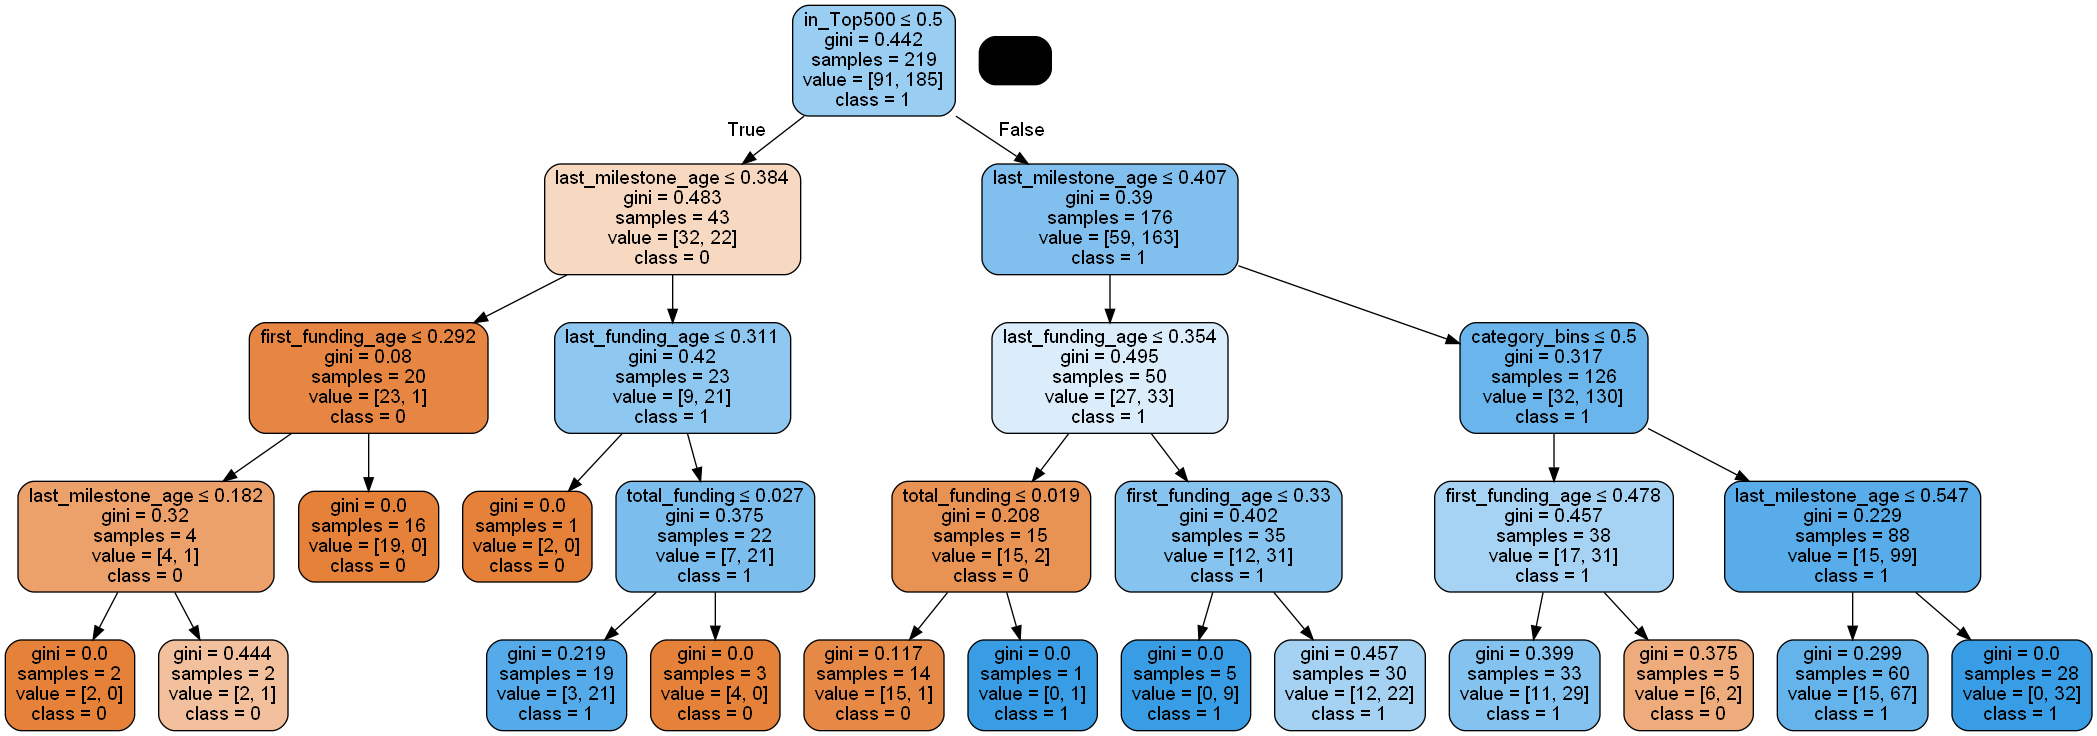

In [203]:
presentTree(rf_grid2.best_estimator_.estimators_[0], X)

Overall we saw that the grid has the best accuracy, but let's also see the AUC and ttest. 

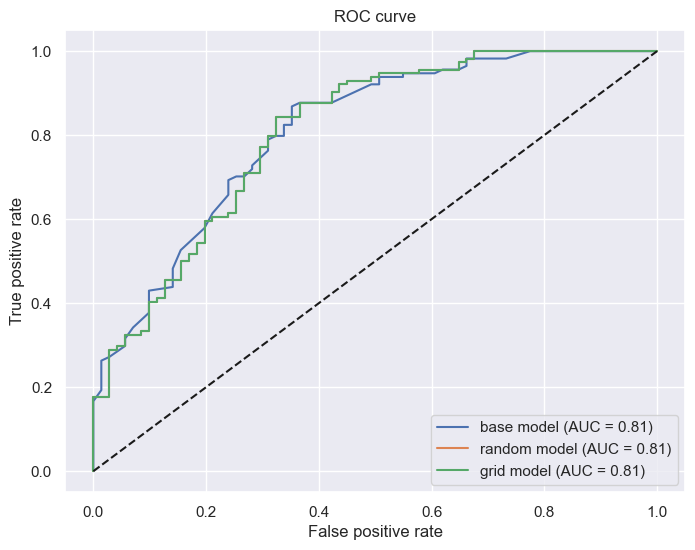

In [205]:
createROC(X_train, y_train, X_test, y_test, [(base_rf_model, 'base'), (rf_random.best_estimator_, 'random'), (rf_grid2.best_estimator_, 'grid')])

In [207]:
rf_models_metrics = {n: evaluate(X, y, m) for n, m in rf_models.items()}
ttest_all_metrics(rf_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.5717063234399874
accept null hypothesis => No one of base and random in better than the other
p-value: 0.5717063234399874
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metric for ttest: recall ---------
p-value: 0.5717063234399874
accept null hypothesis => No one of base and random in better than the other
p-value: 0.5717063234399874
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metric for ttest: precision ---------
p-value: 0.9811761220820283
accept null hypothesis => No one of base and random in better than the other
p-value: 0.9811761220820283
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metric 

## [C] Naïve Bayes Classifier

In this section, the Naïve Bayes Classifier will be studied on our data.
Note that when using the Naïve Bayes Classifier, we assume out features are independant!

Starting with the very basic model:

In [74]:
base_bays_model = GaussianNB()
print_metrics(evaluate(X, y, base_bays_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


A second try, on the **dummies**:

In [75]:
print_metrics(evaluate(Xd, Yd, base_bays_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


Dummy performance isn't great.

We will try to tweak the different parameters in order to find a better configuration:

In [76]:
base_bays_model.get_params()

{'priors': None, 'var_smoothing': 1e-09}

let's try different variable smoothings:

In [145]:
def findBestAlpha(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    options = [10**k for k in range(0, -10, -1)]
    for alpha in options:
        clf = GaussianNB(var_smoothing=alpha)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.semilogx(options, train_scores)
    plt.semilogx(options, test_scores)
    plt.xticks(options)
    plt.legend(['train', 'test'])
    plt.xlabel('alpha')
    plt.ylabel('accuracy')
    plt.show()
    
    # search_on = [test - train for train, test in zip(train_scores, test_scores)]
    arg_best = np.argmax(test_scores)
    return arg_best, test_scores[arg_best]

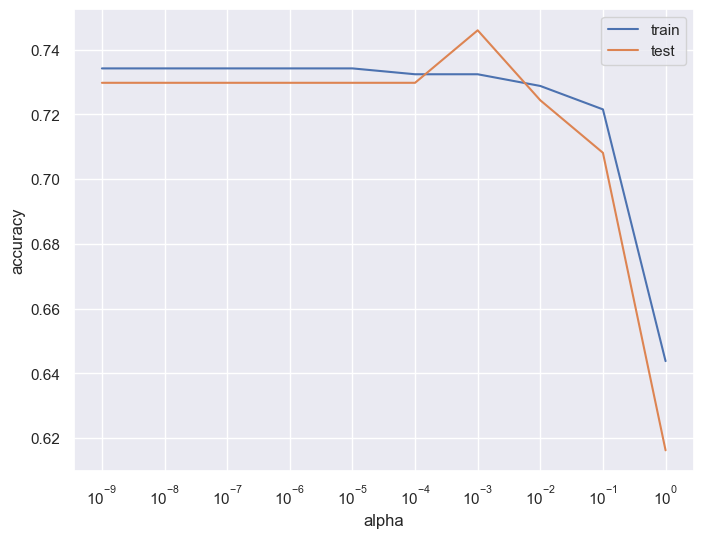

The best alpha is 10^-4 with accuracy of 0.746


In [146]:
best_alpha, best_acc = findBestAlpha(X, y)
print(f'The best alpha is 10^-{best_depth} with accuracy of {best_acc:0.3f}')

In [147]:
best_alpha_model = GaussianNB(var_smoothing=pow(10, -best_alpha))

In [148]:
nb_models = {'base': base_bays_model, 'best_alpha': best_alpha_model}

In [149]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_bays_model, 'base'), (nb_models['best_alpha'], 'best_alpha'))

[base] model accuracy = 72.97%
[best_alpha] model accuracy = 74.59%
Improvement of 2.22%


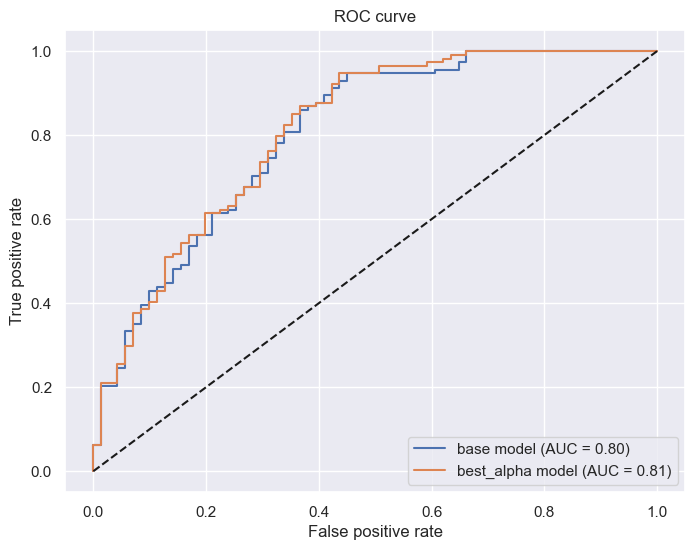

In [150]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_bays_model, 'base'), (nb_models['best_alpha'], 'best_alpha')])

In [151]:
nb_models_metrics = {name: evaluate(X, y, model) for name, model in nb_models.items()}
ttest_all_metrics(nb_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.4775620487754405
accept null hypothesis => No one of base and best_alpha in better than the other

--------- metric for ttest: recall ---------
p-value: 0.4775620487754405
accept null hypothesis => No one of base and best_alpha in better than the other

--------- metric for ttest: precision ---------
p-value: 0.5799647539989603
accept null hypothesis => No one of base and best_alpha in better than the other

--------- metric for ttest: f-score ---------
p-value: 0.3929547441654605
accept null hypothesis => No one of base and best_alpha in better than the other



We can see that we don't have any statistical significance between the different models, but we did saw that the model with the best alpha is the one with the best accuracy, so we'll choose it.

In [152]:
print_metrics(evaluate(X, y, nb_models['best_alpha']))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


## [D] SVM Classifier

In [189]:
base_svm_model = svm.SVC(random_state=RAND, probability=True)
print_metrics(evaluate(X, y, base_svm_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


Accuracy isn't the best, so we'll try to improve it by using hyperparameter tuning.

In [190]:
base_svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

First let's check if the 'C' parameter has an effect on the accuracy.

In [166]:
def findBestC(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)
    train_scores, test_scores = [], []
    options = [x / 100 for x in range(1, 200, 10)]
    for C in options:
        clf = svm.SVC(C=C, random_state=RAND)
        clf.fit(X_train, y_train)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))

    plt.figure(figsize=(8, 6))
    plt.plot(options, train_scores)
    plt.plot(options, test_scores)
    plt.legend(['train', 'test'])
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.show()
    
    arg_best = np.argmax(test_scores)
    return round(arg_best/10, 2), test_scores[arg_best]

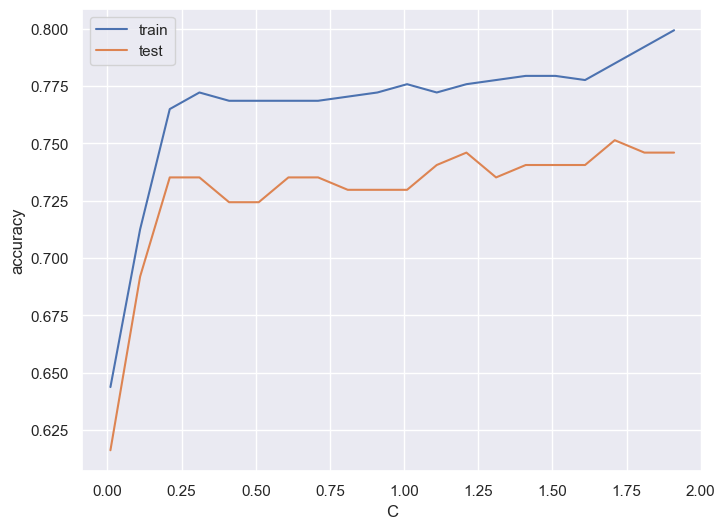

The best C is 1.7 with accuracy of 0.751


In [167]:
best_c, best_c_acc = findBestC(X, y)
print(f'The best C is {best_c} with accuracy of {best_c_acc:0.3f}')

Now let's do a hyperparameter tuning for the SVM model - using random and grid search.

In [169]:
svm_models = {'base': base_svm_model, 'random': None, 'grid': None}

In [181]:
param_grid = {'C': [best_c + i / 10 for i in range(-5, 5)],
               'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'gamma': ['scale', 'auto'],
               'degree': [2, 3, 4, 5],
               'coef0': [0.0, 0.1, 0.2, 0.3, 0.4], 
               'probability': [True]}

In [182]:
svm_random = RandomizedSearchCV(estimator=base_svm_model, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2)

svm_random.fit(X_train, y_train)
svm_models['random'] = svm_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [183]:
svm_random.best_params_

{'probability': True,
 'kernel': 'rbf',
 'gamma': 'scale',
 'degree': 4,
 'coef0': 0.3,
 'C': 1.2}

In [184]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_svm_model, 'base'), (svm_random.best_estimator_, 'random'))

[base] model accuracy = 72.97%
[random] model accuracy = 74.59%
Improvement of 2.22%


In [185]:
svm_grid = GridSearchCV(estimator=base_svm_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

svm_grid.fit(X_train, y_train)
svm_models['grid'] = svm_grid.best_estimator_

Fitting 5 folds for each of 1600 candidates, totalling 8000 fits


In [186]:
svm_grid.best_params_

{'C': 1.2,
 'coef0': 0.0,
 'degree': 2,
 'gamma': 'scale',
 'kernel': 'rbf',
 'probability': True}

In [187]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_svm_model, 'base'), (svm_grid.best_estimator_, 'grid'))

[base] model accuracy = 72.97%
[grid] model accuracy = 74.59%
Improvement of 2.22%


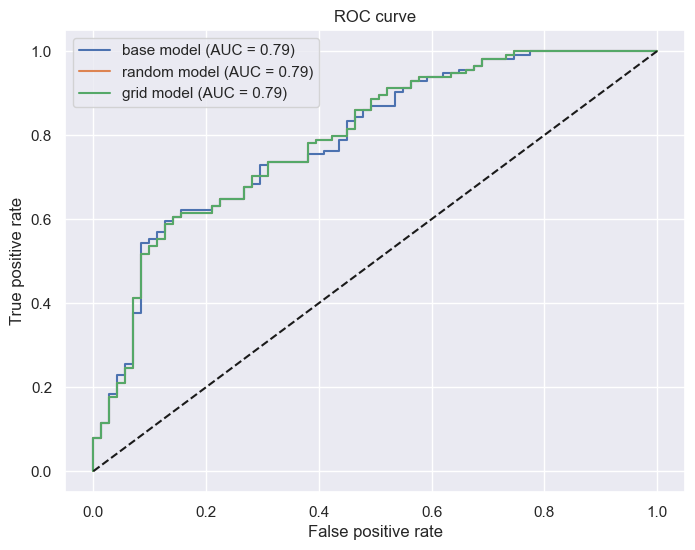

In [191]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_svm_model, 'base'), (svm_random.best_estimator_, 'random'), (svm_grid.best_estimator_, 'grid')])

In [192]:
svm_models_metrics = {name: evaluate(X, y, model) for name, model in svm_models.items()}

ttest_all_metrics(svm_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.1792592369080283
accept null hypothesis => No one of base and random in better than the other
p-value: 0.1792592369080283
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metric for ttest: recall ---------
p-value: 0.1792592369080283
accept null hypothesis => No one of base and random in better than the other
p-value: 0.1792592369080283
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metric for ttest: precision ---------
p-value: 0.15647301065930105
accept null hypothesis => No one of base and random in better than the other
p-value: 0.15647301065930105
accept null hypothesis => No one of base and grid in better than the other
random and grid have the same metric => No one is better than the other

--------- metri

In [193]:
print_metrics(evaluate(X, y, svm_models['grid']))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


## [E] K-NN Classifier 

In [119]:
base_knn_model = KNeighborsClassifier()

In [121]:
print_metrics(evaluate(X, y, base_knn_model))

Confusion table of train:


Confusion table of test:


Metrics for train set:


Metrics for test set:


Same as before, we'll try to find the best hyper-parameters for the K-NN model.

In [122]:
knn_models = {'base': base_knn_model, 'random': None, 'grid': None}

In [123]:
base_knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [124]:
algs = ['ball_tree', 'kd_tree', 'brute']
# all_mtrcs = set()  # [set(sklearn.neighbors.VALID_METRICS[x]) for x in algs]
# for alg in algs:
#     for mtr in sklearn.neighbors.VALID_METRICS[alg]:
#         all_mtrcs.add(mtr)

all_mtrcs = [set(sklearn.neighbors.VALID_METRICS[x]) for x in algs]
unique_mtrcs= set()
for x in all_mtrcs:
    unique_mtrcs |= x
        
# print(unique_mtrcs)
survivers = ['euclidean', 'cosine', 'haversine', 'infinity', 'manhattan']
        
param_grid = { 'algorithm': algs,
               'leaf_size': list(range(20, 91, 7)),
               'metric': survivers,  
               'n_neighbors': list(range(5, 21)),
               'weights': ['uniform', 'distance']}

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RAND)

knn_random = RandomizedSearchCV(estimator=base_knn_model, param_distributions=param_grid, n_iter=100, cv=5,
                                verbose=5, random_state=RAND, n_jobs=-1)

knn_random.fit(X_train, y_train)

knn_models['random'] = knn_random.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
190 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\nei

In [126]:
knn_random.best_params_

{'weights': 'uniform',
 'n_neighbors': 11,
 'metric': 'manhattan',
 'leaf_size': 83,
 'algorithm': 'ball_tree'}

In [127]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_knn_model, 'base'), (knn_random.best_estimator_, 'random'))

[base] model accuracy = 69.19%
[random] model accuracy = 74.05%
Improvement of 7.03%


In [128]:
knn_grid = GridSearchCV(estimator=base_knn_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

knn_grid.fit(X_train, y_train)

knn_models['grid'] = knn_grid.best_estimator_

Fitting 5 folds for each of 5280 candidates, totalling 26400 fits


c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
8800 fits failed out of a total of 26400.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1760 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\liri\AppData\Local\Programs\Python\Python38\lib\site-packages\sklear

In [129]:
knn_grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 20,
 'metric': 'manhattan',
 'n_neighbors': 11,
 'weights': 'uniform'}

In [130]:
compare_accuracy(X_train, y_train, X_test, y_test, (base_knn_model, 'base'), (knn_grid.best_estimator_, 'grid'))

[base] model accuracy = 69.19%
[grid] model accuracy = 74.05%
Improvement of 7.03%


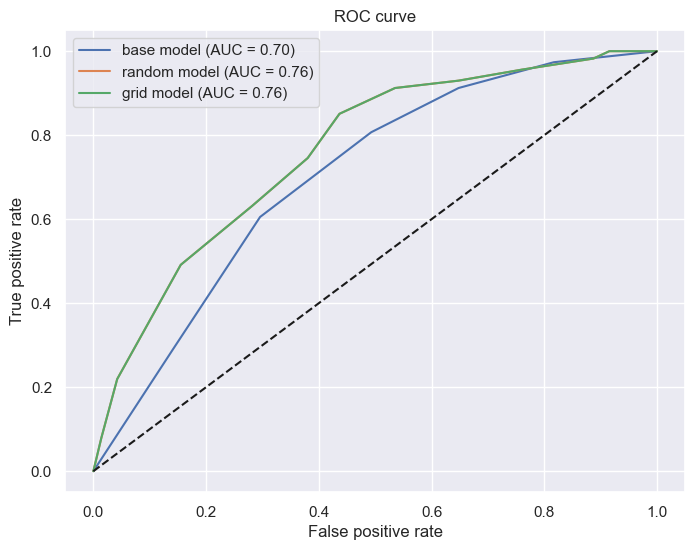

In [131]:
_ = createROC(X_train, y_train, X_test, y_test, [(base_knn_model, 'base'), (knn_random.best_estimator_, 'random'), (knn_grid.best_estimator_, 'grid')])

In [132]:
knn_models_metrics = {name: evaluate(X, y, model) for name, model in knn_models.items()}
ttest_all_metrics(knn_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.004696837536927161
reject null hypothesis => random is BETTER THAN base
p-value: 0.004696837536927161
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: recall ---------
p-value: 0.004696837536927161
reject null hypothesis => random is BETTER THAN base
p-value: 0.004696837536927161
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: precision ---------
p-value: 0.0033010444946732663
reject null hypothesis => random is BETTER THAN base
p-value: 0.0033010444946732663
reject null hypothesis => grid is BETTER THAN base
random and grid have the same metric => No one is better than the other

--------- metric for ttest: f-score ---------
p-value: 0.009001048151182637
reject null hypothesis => random is BETTER THAN base
p-value: 0.0090010

## Selecting the best model

In [278]:
def plot_metrics(models_metrics):
    our_metrics = ['accuracy', 'precision', 'recall', 'f-score']
    df_mean_metrics = pd.DataFrame(columns=our_metrics)
    
    for name, metrics in models_metrics.items():
        df_mean_metrics = pd.concat([df_mean_metrics, pd.DataFrame({metric: np.mean(metrics[metric][1]) for metric in our_metrics}, index=[name])], axis=0)

    # now only need to present this dataframe in a bar plot for each metric in different 
    fig, axes = plt.subplots(2, 2, figsize=(18, 12.5))
    fig.suptitle("Metrics comparison")
    for idx, metric in enumerate(our_metrics):
        df_mean_metrics[metric].plot(kind='bar', color=[(x/10.0, x/20.0, 0.75) for x in range(0, 10, 2)], ax=axes[idx // 2, idx % 2])
        axes[idx // 2, idx % 2].set_title(f'{metric} comparison')
        axes[idx // 2, idx % 2].set_xlabel('Model')
        axes[idx // 2, idx % 2].set_xlabel(metric)
        # plt.xlabel('Model')
        # plt.ylabel(metric)
    plt.show()

In [208]:
our_models = {'DT': dt_models['grid'], 'RF': rf_models['grid'], 'NB': nb_models['best_alpha'], 'SVM': svm_models['grid'], 'KNN': knn_models['grid']}

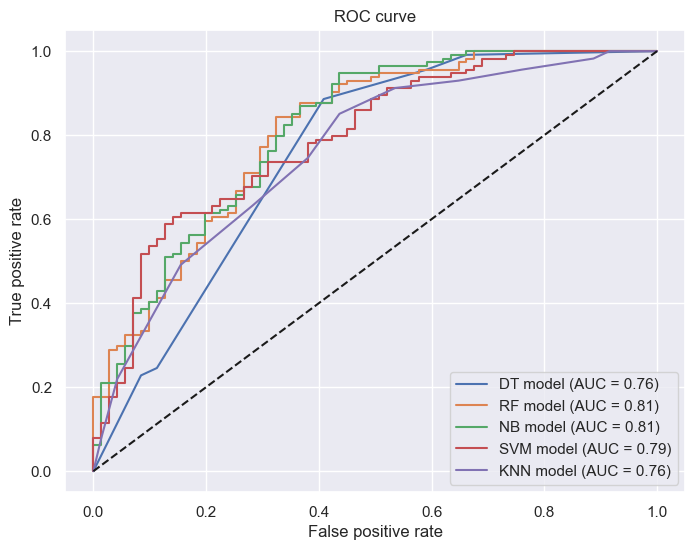

In [210]:
_ = createROC(X_train, y_train, X_test, y_test, [(model, name) for name, model in our_models.items()])

In [ ]:
our_models_metrics = {name: evaluate(X, y, model) for name, model in our_models.items()}

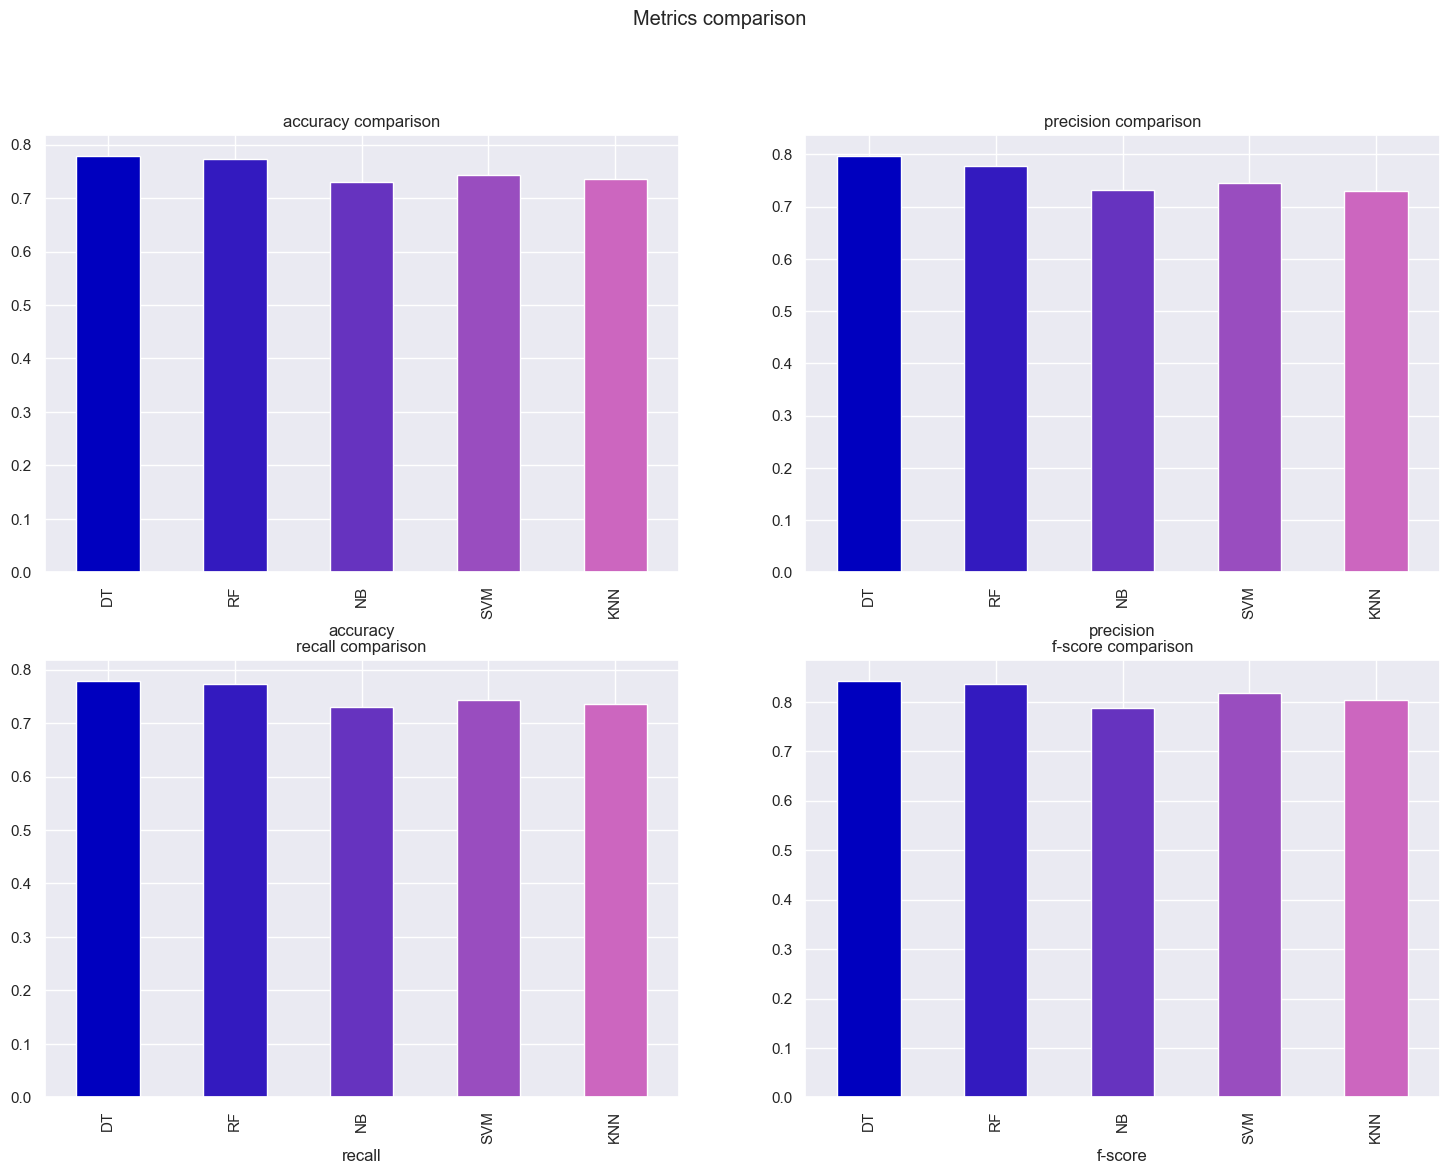

In [279]:
plot_metrics(our_models_metrics)

In [282]:
ttest_all_metrics(our_models_metrics)

--------- metric for ttest: accuracy ---------
p-value: 0.765216928145394
accept null hypothesis => No one of DT and RF is better than the other
p-value: 0.15963186246113004
accept null hypothesis => No one of DT and NB is better than the other
p-value: 0.23065664659165086
accept null hypothesis => No one of DT and SVM is better than the other
p-value: 0.11389924000338789
accept null hypothesis => No one of DT and KNN is better than the other
p-value: 0.039693382903925344
reject null hypothesis => RF is BETTER THAN NB
p-value: 0.027647804260171653
reject null hypothesis => RF is BETTER THAN SVM
p-value: 0.016670829666654535
reject null hypothesis => RF is BETTER THAN KNN
p-value: 0.4754206499150175
accept null hypothesis => No one of NB and SVM is better than the other
p-value: 0.6390699585670223
accept null hypothesis => No one of NB and KNN is better than the other
p-value: 0.5095143269925033
accept null hypothesis => No one of SVM and KNN is better than the other

--------- metric f